## Libraries

In [1]:
import abc
import codecs
import inspect
import json
import logging
import gc
import os
import pickle
import random
import sys
import time
import warnings

import catboost as cat
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from abc import abstractmethod
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence

from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm_notebook

## Config

In [2]:
lgb_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - Basic
  - PastAssessment
  - PastClip

av:
  split_params:
    n_splits: 5
    random_state: 42

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 200
    verbose_eval: 200

model:
  name: "lgbm"
  model_params:
    objective: "regression"
    metric: "rmse"
    boosting_type: "gbdt"
    max_depth: -1
    num_leaves: 256
    tree_learner: "serial"
    learning_rate: 0.01
    subsample: 0.7
    subsample_freq: 1
    colsample_bytree: 0.5
    max_bin: 255
    seed: 71
    bagging_seed: 71
    feature_fraction_seed: 71
    drop_seed: 71
    verbose: -1
    first_metric_only: False

  train_params:
    num_boost_round: 10000
    early_stopping_rounds: 100
    verbose_eval: 100

post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  n_delete: 25
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''

In [3]:
config = dict(yaml.load(lgb_conf_string, Loader=yaml.SafeLoader))

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    
seed_everything(42)

## Functions and Classes

### utils

#### checker

In [5]:
def feature_existence_checker(feature_path: Path,
                              feature_names: List[str]) -> bool:
    features = [f.name for f in feature_path.glob("*.ftr")]
    for f in feature_names:
        if f + "_train.ftr" not in features:
            return False
        if f + "_valid.ftr" not in features:
            return False
        if f + "_test.ftr" not in features:
            return False
    return True

#### jsonutil

In [6]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [7]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [8]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

### validation

In [9]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = KFold(
        n_splits=params["n_splits"],
        random_state=params["random_state"],
        shuffle=True)
    uniq_groups = groups.unique()
    split = []
    for trn_grp_idx, val_grp_idx in kf.split(uniq_groups):
        trn_grp = uniq_groups[trn_grp_idx]
        val_grp = uniq_groups[val_grp_idx]
        trn_idx = df[df["group"].isin(trn_grp)].index.values
        val_idx = df[df["group"].isin(val_grp)].index.values
        split.append((trn_idx, val_idx))

    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        groups = df["group"]
        return func(df, groups, config)
    else:
        return func(df, config)

#### feature_selection

In [10]:
def select_features(cols: List[str], feature_importance: pd.DataFrame,
                    config: dict) -> List[str]:
    if config["val"].get("n_delete") is None:
        return cols

    n_delete = config["val"].get("n_delete")
    importance_sorted_cols = feature_importance.sort_values(
        by="value", ascending=False)["feature"].tolist()
    if isinstance(n_delete, int):
        remove_cols = importance_sorted_cols[:n_delete]
        for col in remove_cols:
            cols.remove(col)
    elif isinstance(n_delete, float):
        n_delete_int = int(n_delete * len(importance_sorted_cols))
        remove_cols = importance_sorted_cols[:n_delete_int]
        for col in remove_cols:
            cols.remove(col)
    return cols

### evaluation

#### metrics

In [11]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [12]:
class OptimizedRounder(object):
    def __init__(self, n_overall: int = 5, n_classwise: int = 5):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.4), (0.4, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            for idx in range(3):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p

#### cat

In [13]:
class CatBoostOptimizedQWKMetric(object):
    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(n_classwise=5, n_overall=5)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

#### lgbm

In [14]:
def lgb_classification_qwk(y_pred: np.ndarray,
                           data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_regression_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = (data.get_label() * 3).astype(int)
    y_pred = y_pred.reshape(-1)

    OptR = OptimizedRounder(n_classwise=5, n_overall=5)
    OptR.fit(y_pred, y_true)

    y_pred = OptR.predict(y_pred).astype(int)
    qwk = calc_metric(y_true, y_pred)

    return "qwk", qwk, True

### models

#### base

In [15]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseModel(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        return oof_preds, test_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.ndarray, pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            # train model
            model, best_score = self.fit(x_trn, y_trn, x_val, y_val, config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds[val_idx] = self.predict(model, x_val).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)
        
        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds

        # post_process (if you have any)
        oof_preds, test_preds = self.post_process(oof_preds, test_preds,
                                                  y_train)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        return models, oof_preds, test_preds, feature_importance, evals_results

#### cat

In [16]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class CatBoost(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["train_params"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(), **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / y_valid.max()
        else:
            model = CatBoostClassifier(**model_params)

        model.fit(
            x_train,
            y_train,
            eval_set=(x_valid, y_valid),
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # Override
        if self.mode == "regression":
            OptR = OptimizedRounder(n_overall=20, n_classwise=20)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            return oof_preds_, test_preds_
        return oof_preds, test_preds

#### lgbm

In [17]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class LightGBM(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = model_params["objective"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        if mode == "regression":
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=[d_valid, d_train],
                valid_names=["valid", "train"],
                feval=lgb_regression_qwk,
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=[d_valid, d_train],
                valid_names=["valid", "train"],
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # Override
        if self.mode == "regression":
            OptR = OptimizedRounder(n_overall=20, n_classwise=20)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            return oof_preds_, test_preds_
        return oof_preds, test_preds

#### factory

In [18]:
def catboost() -> CatBoost:
    return CatBoost()


def lgbm() -> LightGBM:
    return LightGBM()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

### features

#### base

In [19]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.valid = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.ftr"
        self.valid_path = Path(self.save_dir) / f"{self.name}_valid.ftr"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.ftr"

    def run(self,
            train_df: pd.DataFrame,
            test_df: Optional[pd.DataFrame] = None,
            log: bool = False):
        with timer(self.name, log=log):
            self.create_features(train_df, test_df)
            prefix = self.prefix + "_" if self.prefix else ""
            suffix = self.suffix + "_" if self.suffix else ""
            self.train.columns = pd.Index([str(c) for c in self.train.columns])
            self.valid.columns = pd.Index([str(c) for c in self.valid.columns])
            self.test.columns = pd.Index([str(c) for c in self.test.columns])
            self.train.columns = prefix + self.train.columns + suffix
            self.valid.columns = prefix + self.valid.columns + suffix
            self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df: pd.DataFrame,
                        test_df: Optional[pd.DataFrame]):
        raise NotImplementedError

    def save(self):
        self.train.to_feather(str(self.train_path))
        self.valid.to_feather(str(self.valid_path))
        self.test.to_feather(str(self.test_path))


class PartialFeature(metaclass=abc.ABCMeta):
    def __init__(self):
        self.df = pd.DataFrame

    @abc.abstractmethod
    def create_features(self, df: pd.DataFrame, test: bool = False):
        raise NotImplementedError


def is_feature(klass) -> bool:
    return "is_feature" in set(dir(klass))


def get_features(namespace: dict):
    for v in namespace.values():
        if inspect.isclass(v) and is_feature(v) and not inspect.isabstract(v):
            yield v()


def generate_features(train_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      namespace: dict,
                      overwrite: bool,
                      log: bool = False):
    for f in get_features(namespace):
        if (f.train_path.exists() and f.valid_path.exists()
                and f.test_path.exists() and not overwrite):
            if not log:
                print(f.name, "was skipped")
            else:
                logging.info(f"{f.name} was skipped")
        else:
            f.run(train_df, test_df, log).save()


def load_features(config: dict) -> Tuple[pd.DataFrame, pd.DataFrame]:
    feather_path = config["dataset"]["feature_dir"]

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_train.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_train.ftr").exists()
    ]
    x_train = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_valid.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_valid.ftr").exists()
    ]
    x_valid = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_test.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_test.ftr").exists()
    ]
    x_test = pd.concat(dfs, axis=1)
    return x_train, x_valid, x_test

#### basic

In [20]:
IoF = Union[int, float]
IoS = Union[int, str]


class Basic(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()
        all_activities = set(train_df["title"].unique()).union(
            set(test_df["title"].unique()))
        all_event_codes = set(train_df["event_code"].unique()).union(
            test_df["event_code"].unique())
        activities_map = dict(
            zip(all_activities, np.arange(len(all_activities))))
        inverse_activities_map = dict(
            zip(np.arange(len(all_activities)), all_activities))

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_valid: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []

        installation_ids_train = []
        installation_ids_valid = []
        installation_ids_test = []

        train_df["title"] = train_df["title"].map(activities_map)
        test_df["title"] = test_df["title"].map(activities_map)

        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        for ins_id, user_sample in tqdm(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train features"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feats = KernelFeatures(all_activities, all_event_codes,
                                   activities_map, inverse_activities_map)
            feat_df, _ = feats.create_features(user_sample, test=False)

            installation_ids_train.extend([ins_id] * len(feat_df))
            compiled_data_train.append(feat_df)
        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train["installation_id"] = installation_ids_train
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test features"):
            feats = KernelFeatures(all_activities, all_event_codes,
                                   activities_map, inverse_activities_map)
            feat_df, valid_df = feats.create_features(user_sample, test=True)
            installation_ids_valid.extend(
                [ins_id] * len(valid_df))  # type: ignore
            installation_ids_test.extend([ins_id] * len(feat_df))
            compiled_data_valid.append(valid_df)
            compiled_data_test.append(feat_df)
        self.valid = pd.concat(compiled_data_valid, axis=0, sort=False)
        self.valid["installation_id"] = installation_ids_valid
        self.valid.reset_index(drop=True, inplace=True)

        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test["installation_id"] = installation_ids_test
        self.test.reset_index(drop=True, inplace=True)


class KernelFeatures(PartialFeature):
    def __init__(self, all_activities: set, all_event_codes: set,
                 activities_map: Dict[str, float],
                 inverse_activities_map: Dict[float, str]):
        self.all_activities = all_activities
        self.all_event_codes = all_event_codes
        self.activities_map = activities_map
        self.inverse_activities_map = inverse_activities_map

        win_code = dict(
            zip(activities_map.values(),
                (4100 * np.ones(len(activities_map))).astype(int)))
        win_code[activities_map["Bird Measurer (Assessment)"]] = 4110
        self.win_code = win_code

        super().__init__()

    def create_features(self, df: pd.DataFrame, test: bool = False
                        ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        time_spent_each_act = {act: 0 for act in self.all_activities}
        event_code_count = {ev: 0 for ev in self.all_event_codes}
        user_activities_count: Dict[IoS, IoF] = {
            "Clip": 0,
            "Activity": 0,
            "Assessment": 0,
            "Game": 0
        }

        all_assesments = []

        accumulated_acc_groups = 0
        accumulated_acc = 0
        accumulated_correct_attempts = 0
        accumulated_failed_attempts = 0
        accumulated_actions = 0

        counter = 0

        accuracy_group: Dict[int, int] = {0: 0, 1: 0, 2: 0, 3: 0}

        durations: List[float] = []
        last_activity = ""

        for i, sess in df.groupby("game_session", sort=False):
            sess_type = sess["type"].iloc[0]
            sess_title = sess["title"].iloc[0]

            if sess_type != "Assessment":
                time_spent = int(sess["game_time"].iloc[-1] / 1000)
                time_spent_each_act[
                    self.inverse_activities_map[sess_title]] += time_spent

            if sess_type == "Assessment" and (test or len(sess) > 1):
                all_attempts: pd.DataFrame = sess.query(
                    f"event_code == {self.win_code[sess_title]}")
                true_attempt = all_attempts["event_data"].str.contains(
                    "true").sum()
                false_attempt = all_attempts["event_data"].str.contains(
                    "false").sum()

                features = user_activities_count.copy()
                features.update(time_spent_each_act.copy())
                features.update(event_code_count.copy())

                features["session_title"] = sess_title

                features["accumulated_correct_attempts"] = \
                    accumulated_correct_attempts
                features["accumulated_failed_attempts"] = \
                    accumulated_failed_attempts

                accumulated_correct_attempts += true_attempt
                accumulated_failed_attempts += false_attempt

                features["duration_mean"] = np.mean(
                    durations) if durations else 0
                durations.append((sess.iloc[-1, 2] - sess.iloc[0, 2]).seconds)

                features["accumulated_acc"] = \
                    accumulated_acc / counter if counter > 0 else 0

                acc = true_attempt / (true_attempt + false_attempt) \
                    if (true_attempt + false_attempt) != 0 else 0
                accumulated_acc += acc

                if acc == 0:
                    features["accuracy_group"] = 0
                elif acc == 1:
                    features["accuracy_group"] = 3
                elif acc == 0.5:
                    features["accuracy_group"] = 2
                else:
                    features["accuracy_group"] = 1

                features.update(accuracy_group.copy())
                accuracy_group[features["accuracy_group"]] += 1

                features["accumulated_accuracy_group"] = \
                    accumulated_acc_groups / counter if counter > 0 else 0
                accumulated_acc_groups += features["accuracy_group"]

                features["accumulated_actions"] = accumulated_actions

                if len(sess) == 1:
                    all_assesments.append(features)
                elif true_attempt + false_attempt > 0:
                    all_assesments.append(features)

                counter += 1

            num_event_codes: dict = sess["event_code"].value_counts().to_dict()
            for k in num_event_codes.keys():
                event_code_count[k] += num_event_codes[k]

            accumulated_actions += len(sess)
            if last_activity != sess_type:
                user_activities_count[sess_type] + +1
                last_activity = sess_type

        if test:
            df = pd.DataFrame([all_assesments[-1]])
            valid_df = pd.DataFrame(all_assesments[:-1])
            return df, valid_df
        else:
            df = pd.DataFrame(all_assesments)
            return df, None

#### past_assessment

In [21]:
class PastAssessment(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()
        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_valid: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []

        for ins_id, user_sample in tqdm(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train past assessment"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feat_df, _ = past_assess_features(user_sample, test=False)

            compiled_data_train.append(feat_df)
        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test past assessment"):
            feat_df, valid_df = past_assess_features(user_sample, test=True)
            compiled_data_valid.append(valid_df)
            compiled_data_test.append(feat_df)
        self.valid = pd.concat(compiled_data_valid, axis=0, sort=False)
        self.valid.reset_index(drop=True, inplace=True)
        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test.reset_index(drop=True, inplace=True)


def past_assess_features(user_sample: pd.DataFrame, test: bool = False
                         ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    all_assesments = []
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        if sess["type"].iloc[0] != "Assessment":
            continue

        if sess["type"].iloc[0] == "Assessment" and (test or len(sess) > 1):
            features: Dict[str, IoF] = {}
            # only Assessment session will be go through here after
            sess_start_idx: int = sess.index.min()
            sess_title: str = sess.title.iloc[0]
            history: pd.DataFrame = user_sample.loc[:sess_start_idx - 1, :]

            features["has_same_assessment_in_past"] = \
                int(sess_title in history["title"].unique())
            features["n_same_assessment_in_past"] = \
                history.query(
                    f"title == '{sess_title}'"
                )["game_session"].nunique()

            dur_from_last_assessment = np.iinfo(np.int).max
            if "Assessment" in history["type"].unique():
                delta = (sess.timestamp.min() -
                         history.query("type == 'Assessment'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            dur_from_last_assessment = np.iinfo(np.int).max
            if features["has_same_assessment_in_past"] == 1:
                delta = (
                    sess.timestamp.min() -
                    history.query(f"title == '{sess_title}'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_same_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            # work on the same assessments
            if features["has_same_assessment_in_past"] == 1:
                same_assessments = history.query(f"title == '{sess_title}'")
                attempt_code = 4110 if (
                    sess_title == "Bird Measurer (Assessment)") else 4100
                all_attempts = same_assessments.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_same_assess"] = succ_attempts
                features["n_failure_same_assess"] = fail_attempts
                features["success_ratio_same_assess"] = succ_attempts / len(
                    all_attempts) if len(all_attempts) != 0 else 0

                # work on the last same assessment
                sess_id_last_same_assess = same_assessments[
                    "game_session"].unique()[-1]
                last_same_assess = history.query(
                    f"game_session == '{sess_id_last_same_assess}'")
                all_attempts = last_same_assess.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_last_same_assess"] = succ_attempts
                features["n_failure_last_same_assess"] = fail_attempts
                acc = succ_attempts / len(all_attempts) \
                    if len(all_attempts) != 0 else 0
                features["success_ratio_last_same_assess"] = acc
                if acc == 0:
                    features["last_same_accuracy_group"] = 0
                elif acc == 1:
                    features["last_same_accuracy_group"] = 3
                elif acc == 0.5:
                    features["last_same_accuracy_group"] = 2
                else:
                    features["last_same_accuracy_group"] = 1
            else:
                features["n_success_same_assess"] = -1
                features["n_failure_same_assess"] = -1
                features["success_ratio_same_assess"] = -1
                features["n_success_last_same_assess"] = -1
                features["n_failure_last_same_assess"] = -1
                features["success_ratio_last_same_assess"] = -1
                features["last_same_accuracy_group"] = -1
            for col in [
                    "last_same_accuracy_group", "n_failure_last_same_assess",
                    "n_success_last_same_assess",
                    "success_ratio_last_same_assess"
            ]:
                features["decayed_" + col] = features[col] * features[
                    "memory_decay_coeff_from_last_same_assess"]

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts = sess.query(f"event_code == {attempt_code}")
            if len(sess) == 1:
                all_assesments.append(features)
            elif len(all_attempts) > 0:
                all_assesments.append(features)

    if test:
        all_assess_df = pd.DataFrame([all_assesments[-1]])
        valid_df = pd.DataFrame(all_assesments[:-1])
        return all_assess_df, valid_df
    else:
        all_assess_df = pd.DataFrame(all_assesments)
        return all_assess_df, None

#### past_clip

In [37]:
class PastClip(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()
        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        compiled_data_train: List[pd.DataFrame] = []
        compiled_data_valid: List[pd.DataFrame] = []
        compiled_data_test: List[pd.DataFrame] = []
        for ins_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train past clip"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feat_df, _ = past_clip_features(user_sample, test=False)
            compiled_data_train.append(feat_df)

        self.train = pd.concat(compiled_data_train, axis=0, sort=False)
        self.train.reset_index(drop=True, inplace=True)

        for ins_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test past clip"):
            feat_df, valid_df = past_clip_features(user_sample, test=True)
            compiled_data_valid.append(valid_df)
            compiled_data_test.append(feat_df)
        self.valid = pd.concat(compiled_data_valid, axis=0, sort=False)
        self.valid.reset_index(drop=True, inplace=True)
        self.test = pd.concat(compiled_data_test, axis=0, sort=False)
        self.test.reset_index(drop=True, inplace=True)


def past_clip_features(user_sample: pd.DataFrame, test: bool = False
                       ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    clip_length = {
        "12 Monkeys": 120,
        "Balancing Act": 90,
        "Costume Box": 80,
        "Heavy, Heavier, Heaviest": 80,
        "Honey Cake": 160,
        "Lifting Heavy Things": 130,
        "Ordering Spheres": 75,
        "Pirate's Tale": 95,
        "Rulers": 140,
        "Slop Problem": 75,
        "Treasure Map": 170
    }

    title_clip_relation = {
        "Mushroom Sorter (Assessment)":
        ["12 Monkeys", "Costume Box", "Ordering Spheres", "Pirate's Tale"],
        "Bird Measurer (Assessment)": ["Bird Measurer", "Treasure Map"],
        "Cauldron Filler (Assessment)": ["Slop Problem"],
        "Cart Balancer (Assessment)":
        ["Balancing Act", "Honey Cake", "Lifting Heavy Things"],
        "Chest Sorter (Assessment)": ["Heavy, Heavier, Heaviest"]
    }
    all_assessments = []
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        if sess["type"].iloc[0] != "Assessment":
            continue

        if sess["type"].iloc[0] == "Assessment" and (test or len(sess) > 1):
            features: Dict[str, IoF] = {}
            # only Assessment session will go through here after
            sess_start_idx: int = sess.index.min()
            sess_title: str = sess.title.iloc[0]
            history: pd.DataFrame = user_sample.loc[:sess_start_idx - 1, :]

            relevant_clips = title_clip_relation[sess_title]
            clips_in_history = history.query("type == 'Clip'")
            watched_clips_names = clips_in_history["title"].unique()
            all_useful_clips = list(clip_length.keys())
            for clip in all_useful_clips:
                features[clip + "_completion"] = 0.0
                features["last_" + clip + "_completion"] = 0.0
                features["n_complete_" + clip] = 0.0
            features["avg_relevant_clips_completion"] = 0.0
            features["avg_n_complete_relevant_clips"] = 0.0
            features["last_relevant_clips_completion"] = 0.0
            
            relevant_clips_completion = []

            for clip in all_useful_clips:
                if clip in watched_clips_names:
                    past_clips = clips_in_history[clips_in_history["title"].
                                                  str.contains(clip)]
                    past_clips_idx = past_clips.index.values
                    completions = []
                    for idx in past_clips_idx:
                        if idx + 1 > history.index.max():
                            next_sess = sess.iloc[0, :]
                        else:
                            next_sess = history.loc[idx + 1, :]
                        pclip = past_clips.loc[idx, :]
                        if next_sess["installation_id"] != pclip[
                                "installation_id"]:
                            continue
                        duration = (
                            next_sess.timestamp - pclip.timestamp).seconds
                        completions.append(duration / clip_length[clip])
                    if len(completions) == 0:
                        continue
                    features[clip + "_completion"] = max(completions)
                    features["last_" + clip + "_completion"] = completions[-1]
                    features["n_complete_" + clip] = (np.array(completions) >
                                                      0.8).sum()
                    if clip in relevant_clips:
                        relevant_clips_completion.append(max(completions))
            if len(relevant_clips_completion) > 0:
                features["avg_relevant_clips_completion"] = np.mean(
                    relevant_clips_completion)
                features["last_relevant_clips_completion"] = relevant_clips_completion[-1]
                features["avg_n_complete_relevant_clips"] = (
                    np.array(relevant_clips_completion) > 0.8).mean()

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts = sess.query(f"event_code == {attempt_code}")
            if len(sess) == 1:
                all_assessments.append(features)
            elif len(all_attempts) > 0:
                all_assessments.append(features)

    if test:
        all_assess_df = pd.DataFrame([all_assessments[-1]])
        valid_df = pd.DataFrame(all_assessments[:-1])
        return all_assess_df, valid_df
    else:
        all_assess_df = pd.DataFrame(all_assessments)
        return all_assess_df, None

## main

### Settings

In [23]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/lgb_3.yml"
log_dir = "log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

config["args"] = dict()
config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(config["output_dir"])
feature_dir = Path(config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

config["model_output_dir"] = str(output_dir)

### Data/Feature Loading

In [24]:
input_dir = Path(config["dataset"]["dir"])

if not feature_existence_checker(feature_dir, config["features"]):
    with timer(name="load data", log=True):
        train = pd.read_csv(input_dir / "train.csv")
        test = pd.read_csv(input_dir / "test.csv")
        specs = pd.read_csv(input_dir / "specs.csv")
        sample_submission = pd.read_csv(
            input_dir / "sample_submission.csv")

In [38]:
gc.collect()

257

In [39]:
Feature.save_dir = "../features"

generate_features(
        train, test, namespace=globals(), overwrite=False, log=True)

In [40]:
del train, test
gc.collect()

with timer("feature laoding", log=True):
    x_train = pd.concat([
        pd.read_feather(feature_dir / (f + "_train.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                        axis=1,
                        sort=False)
    x_valid = pd.concat([
        pd.read_feather(feature_dir / (f + "_valid.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                        axis=1,
                        sort=False)
    x_test = pd.concat([
        pd.read_feather(feature_dir / (f + "_test.ftr"), nthreads=-1)
        for f in config["features"]
    ],
                       axis=1,
                       sort=False)

groups = x_train["installation_id"].values
y_train = x_train["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

assert len(x_train) == len(y_train)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train)}")
logging.debug(f"numbber of test samples: {len(x_test)}")

### Adversarial Validation

In [41]:
cols = x_train.columns.tolist()

Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.889497	valid's auc: 0.797868
[400]	train's auc: 0.928373	valid's auc: 0.830575
[600]	train's auc: 0.949266	valid's auc: 0.849195
[800]	train's auc: 0.963225	valid's auc: 0.861702
[1000]	train's auc: 0.972826	valid's auc: 0.873531
[1200]	train's auc: 0.978782	valid's auc: 0.880955
[1400]	train's auc: 0.983579	valid's auc: 0.886608
[1600]	train's auc: 0.986815	valid's auc: 0.889397
[1800]	train's auc: 0.989188	valid's auc: 0.891029
[2000]	train's auc: 0.991218	valid's auc: 0.894082
[2200]	train's auc: 0.992841	valid's auc: 0.895589
[2400]	train's auc: 0.994041	valid's auc: 0.899185
[2600]	train's auc: 0.995097	valid's auc: 0.901005
[2800]	train's auc: 0.995748	valid's auc: 0.903439
[3000]	train's auc: 0.996231	valid's auc: 0.903936
[3200]	train's auc: 0.99662	valid's auc: 0.904182
[3400]	train's auc: 0.997001	valid's auc: 0.906616
[3600]	train's auc: 0.997574	valid's auc: 0.908444
[3800]	train's auc: 0.997

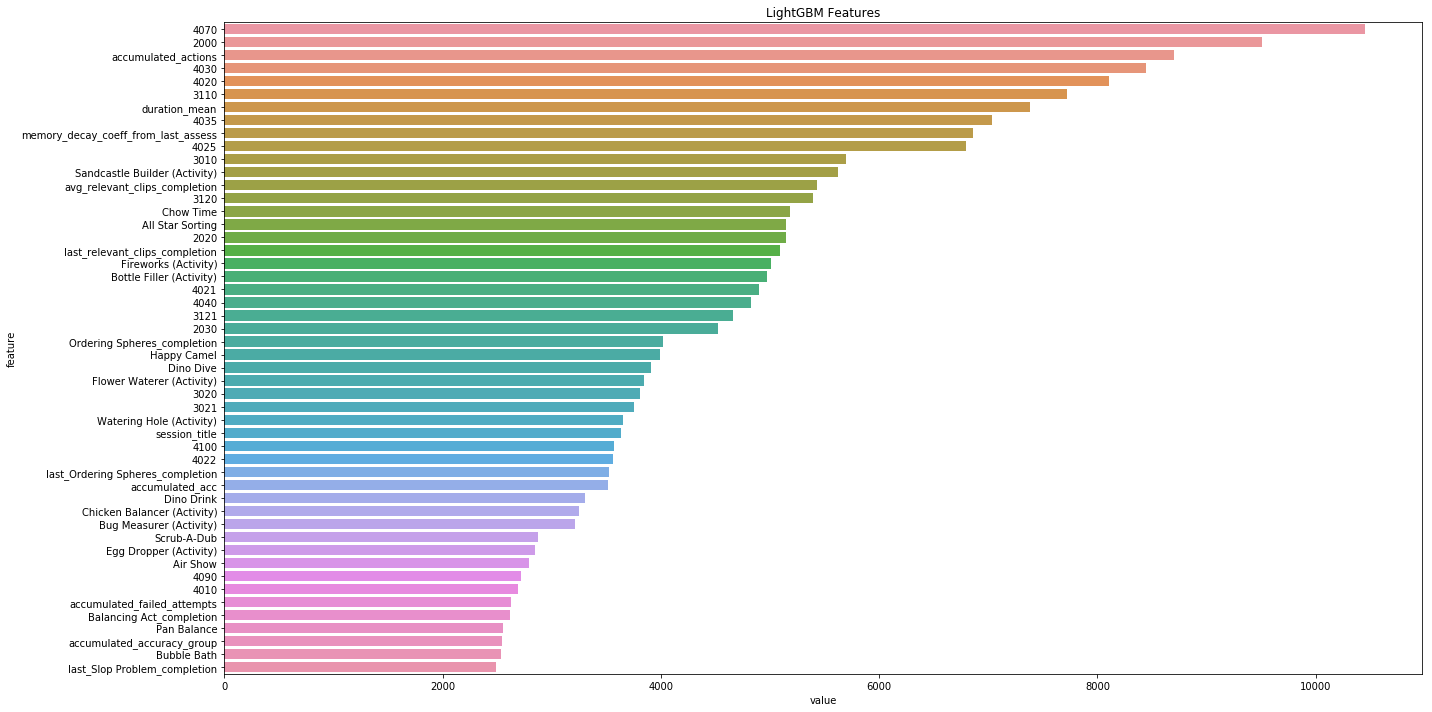

In [42]:
logging.info("Adversarial Validation")
train_adv = x_train.copy()
test_adv = x_valid.copy()

train_adv["target"] = 0
test_adv["target"] = 1
train_test_adv = pd.concat([train_adv, test_adv], axis=0,
                           sort=False).reset_index(drop=True)

split_params: dict = config["av"]["split_params"]
kf = KFold(
    random_state=split_params["random_state"],
    n_splits=split_params["n_splits"],
    shuffle=True)
splits = list(kf.split(train_test_adv))
aucs = []
importance = np.zeros(len(cols))
for trn_idx, val_idx in splits:
    x_train_adv = train_test_adv.loc[trn_idx, cols]
    y_train_adv = train_test_adv.loc[trn_idx, "target"]
    x_val_adv = train_test_adv.loc[val_idx, cols]
    y_val_adv = train_test_adv.loc[val_idx, "target"]

    train_lgb = lgb.Dataset(x_train_adv, label=y_train_adv)
    valid_lgb = lgb.Dataset(x_val_adv, label=y_val_adv)

    model_params = config["av"]["model_params"]
    train_params = config["av"]["train_params"]
    clf = lgb.train(
        model_params,
        train_lgb,
        valid_sets=[train_lgb, valid_lgb],
        valid_names=["train", "valid"],
        **train_params)

    aucs.append(clf.best_score)
    importance += clf.feature_importance(
        importance_type="gain") / len(splits)

# Check the feature importance
feature_imp = pd.DataFrame(
    sorted(zip(importance, cols)), columns=["value", "feature"])

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("LightGBM Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_adv.png")

config["av_result"] = dict()
config["av_result"]["score"] = dict()
for i, auc in enumerate(aucs):
    config["av_result"]["score"][f"fold{i}"] = auc

config["av_result"]["feature_importances"] = \
    feature_imp.set_index("feature").sort_values(
        by="value",
        ascending=False
    ).head(100).to_dict()["value"]

### Train model

#### LGBM model

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.313197	train's qwk: 0.725453	valid's rmse: 0.35427	valid's qwk: 0.551533
[200]	train's rmse: 0.265779	train's qwk: 0.810776	valid's rmse: 0.336887	valid's qwk: 0.606697
[300]	train's rmse: 0.23553	train's qwk: 0.851293	valid's rmse: 0.332309	valid's qwk: 0.616585
[400]	train's rmse: 0.21232	train's qwk: 0.88185	valid's rmse: 0.331291	valid's qwk: 0.617473
Early stopping, best iteration is:
[363]	train's rmse: 0.220304	train's qwk: 0.871599	valid's rmse: 0.331471	valid's qwk: 0.619873
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.312397	train's qwk: 0.727699	valid's rmse: 0.353535	valid's qwk: 0.560807
[200]	train's rmse: 0.264593	train's qwk: 0.8103	valid's rmse: 0.337981	valid's qwk: 0.600857
[300]	train's rmse: 0.234177	train's qwk: 0.854305	valid's rmse: 0.334325	valid's qwk: 0.599191
[400]	train's rmse: 0.210814	train's qwk: 0.88364	valid's rmse: 0.333277	valid'

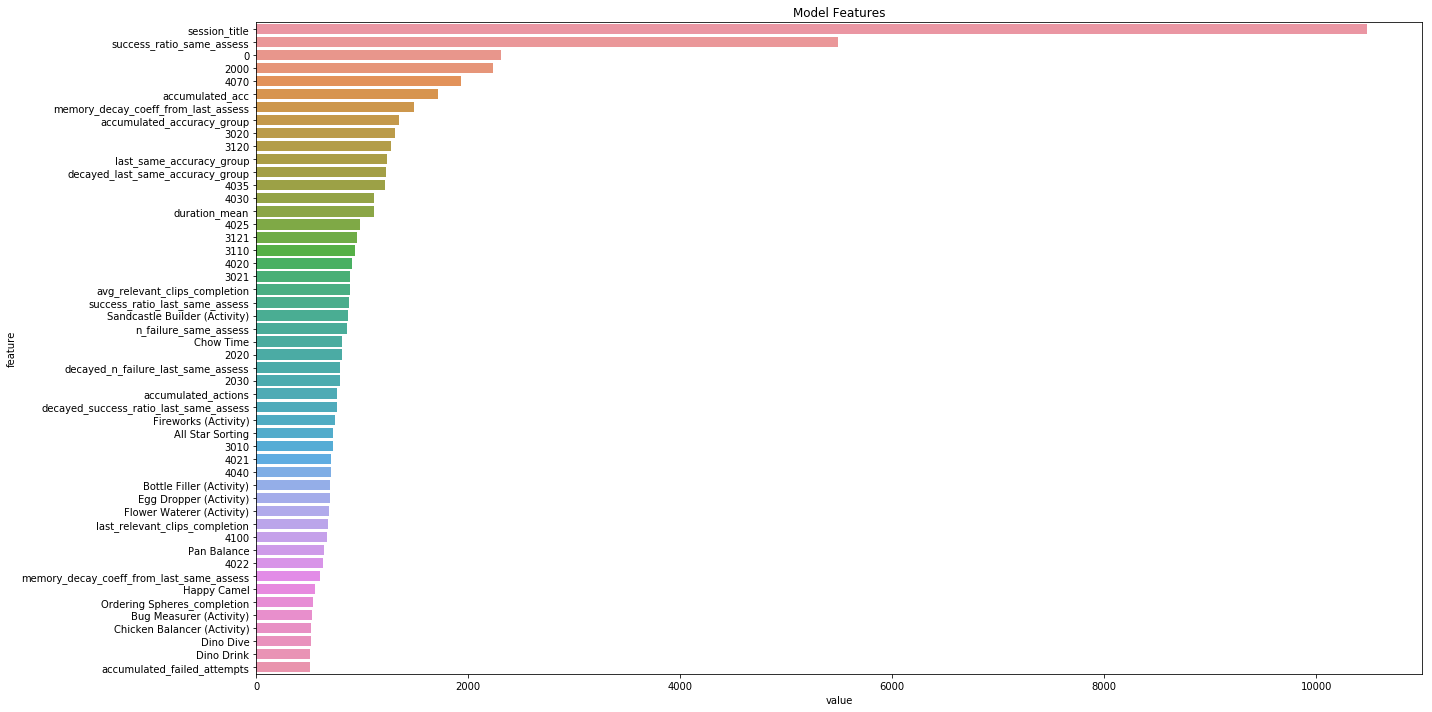

In [43]:
logging.info("Train model")

# get folds
x_train["group"] = groups
splits = get_validation(x_train, config)
x_train.drop("group", axis=1, inplace=True)

config["val"]["n_delete"] = 0
cols = select_features(cols, feature_imp, config)

model = get_model(config)
models, oof_preds, test_preds, feature_importance, eval_results = model.cv(
    y_train, x_train[cols], x_test[cols], cols, splits, config, log=True)

config["eval_results"] = dict()
for k, v in eval_results.items():
    config["eval_results"][k] = v

feature_imp = feature_importance.reset_index().rename(columns={
    "index": "feature",
    0: "value"
})
plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_model.png")

### Save

In [46]:
save_path = output_dir / "output.json"
save_json(config, save_path)
np.save(output_dir / "lgb_oof_preds.npy", oof_preds)
    
with open(output_dir / "lgb_model.pkl", "wb") as m:
    pickle.dump(models, m)

### Make submission

In [47]:
sample_submission = pd.read_csv(
    input_dir / "sample_submission.csv")
sample_submission["accuracy_group"] = test_preds
sample_submission.to_csv('submission.csv', index=None)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
